A friend of mine - who works in digital preservation - was describing how difficult it was to verify the MIME type of files whenever an old digital artwork needs to...be preserved. He was describing how his team uses tools to _manually_ check the bitstring (actually raw hex bytes, apologies for confusing project name) of an unknown file to verify the file's MIME Type.

Since manually reviewing hex strings is insanely tedious, I wanted to see if I could determine a files MIME type by comparing byte strings of other files.


##### General steps performed:
- Load bit strings from files
- Create DataFrame with MultiIndex
- Transform DataFrame to create string pairings for all files
- Create DataFrame's with string comparison values

---

---

In [1]:
import os
import sys
import collections
import numpy as np
import pandas as pd
import jellyfish as jf
from difflib import SequenceMatcher
from bitstring import Bits, BitArray, ConstBitStream, BitStream
import matplotlib.pyplot as plt
%matplotlib inline

print ('python version: ', sys.version_info, '\n')

python version:  sys.version_info(major=3, minor=5, micro=2, releaselevel='final', serial=0) 



In [2]:
os.chdir(os.path.join(os.path.expanduser('~'),'projects'))
media_dir = './bitstrings/media/'
file_name_list = [f for f in os.listdir(media_dir) if os.path.isfile(os.path.join(media_dir, f))]
file_name_list.remove('Thumbs.db')
file_name_list.remove('desktop.ini')
file_bitarrays = {}
file_extensions = []

---
##### Load bit strings from files

In [3]:
load_approach = 0
nbytes = 32*8 # 256 bits aka 32 bytes
if load_approach == 1:
    for file in file_name_list:
        file_name, file_ext = file.rsplit(sep='.', maxsplit=1)
        #print('', file_ext, ' | ', file_ext.lower())
        file_ext = file_ext.lower()
        if file_ext == 'jpeg':
            file_ext = 'jpg'
        file_extensions.append(file_ext.lower())
        if file_ext in file_bitarrays.keys():
            with open((media_dir+file), 'rb') as f:
                packet = ConstBitStream(bytes = f.read(nbytes), length = nbytes*8)
                while(packet.pos < nbytes*8):
                    byte = packet.read(8).uint
                    file_bitarrays[file_ext].append([file_name,chr(byte)])
        else:
            with open((media_dir+file), 'rb') as f:
                packet = ConstBitStream(bytes = f.read(nbytes), length = nbytes*8)
                while(packet.pos < nbytes*8):
                    byte = packet.read(8).uint
                    file_bitarrays[file_ext] = ([file_name,chr(byte)])
else:
    for file in file_name_list:
        file_name, file_ext = file.rsplit(sep='.', maxsplit=1)
        file_ext = file_ext.lower()
        if file_ext == 'jpeg':
            file_ext = 'jpg'
        file_extensions.append(file_ext.lower())
        if file_ext in file_bitarrays.keys():
            with open((media_dir+file), 'rb') as f:
                file_bitarrays[file_ext].append([file_name,BitArray(bytes=f.read(),length=nbytes)])
        else:
            with open((media_dir+file), 'rb') as f:
                file_bitarrays[file_ext] = ([[file_name,BitArray(bytes=f.read(),length=nbytes)]])

print ('Loaded first ', nbytes,' bits ',
       'for ',len(file_extensions),' files ',
       'from ',media_dir,' directory, ',
       'representing ',len(file_bitarrays),' file types\n',sep='')

print ('File types and counts:')
print (pd.Series(np.array(file_extensions)).value_counts())

Loaded first 256 bits for 93 files from ./bitstrings/media/ directory, representing 14 file types

File types and counts:
jpg    32
png    15
pdf    13
avi     6
svg     4
m4a     4
mov     4
mp3     3
mod     2
ino     2
nef     2
mp4     2
wmv     2
3mf     2
dtype: int64


---
##### Create DataFrame with MultiIndex

In [4]:
test_dict={}

for k, v in file_bitarrays.items():
    for key, value in v:
        test_dict.update({(key,k):str(value)})
        
df = pd.DataFrame.from_dict(test_dict,orient='index')

fe = []  # list for file extensions
fn = []  # list for file names
for x in range(len(df.index)):
    fe.append(df.index[x][1])
    fn.append(df.index[x][0])
array = [fe,fn]

tuples = list(zip(*array))
index = pd.MultiIndex.from_tuples(tuples, names=['file_type', 'file_name'])
df = pd.DataFrame(df[0].tolist(), index=index)
print (df.shape)
print ('Preview of df:')
df[:5]

(93, 1)
Preview of df:


,,0
file_type,file_name,
jpg,DSCN0311,0xffd8ffe1f64845786966000049492a00080000000b00...
ino,Final_Sketch,0x2f2f2044485420636f64652066726f6d3a0a2f2f2045...
3mf,Left Curve Track,0x504b03041400000008001459ee46c640ebd5cd000000...
mod,MOV06C,0x000001ba4400040004010189c3f8000001bb001280c4...
avi,SUNP0096,0x5249464650101101415649204c495354ec7f00006864...


---
##### Transform DataFrame to create string pairings for all files
_consider transforming in place if memory is an issue_

In [5]:
dfx = pd.DataFrame([df[0].tolist()] * df.shape[0], index=df.index, columns=df.index)  # make columns for each file
dfx = dfx.applymap(lambda x: list([x]))  # make cell values into lists
dfp = dfx + dfx.T  # create string pairings for each row/column intersection
#dfp.mask(np.triu(np.ones(dfp.shape)).astype(bool))  # If desired, cut off upper triangle of df / array.

---
### _Create DataFrame's with string comparison values_
- jf.levenshtein_distance [link](https://jellyfish.readthedocs.io/en/latest/comparison.html#levenshtein-distance) (other methods available)
- SequenceMatcher [link](https://docs.python.org/3.5/library/difflib.html#difflib.SequenceMatcher.ratio)

_*some models might require that comparison values are normalized or otherwise adjusted prior to modeling_

##### Levenshtein Distance

Levenshtein distance represents the number of insertions, deletions, and subsititutions required to change one word to another.

For example: `levenshtein_distance('berne', 'born') == 2` representing the transformation of the first e to o and the deletion of the second e.

In [6]:
lev_distance_df = dfp.applymap(lambda x: jf.levenshtein_distance(x[0], x[1]))
lev_distance_df.head(10)

file_type                                                         jpg  \
file_name                                                    DSCN0311   
file_type file_name                                                     
jpg       DSCN0311                                                  0   
ino       Final_Sketch                                             53   
3mf       Left Curve Track                                         43   
mod       MOV06C                                                   48   
avi       SUNP0096                                                 50   
jpg       280927                                                   41   
png       VIGNELLI_EDITED_TRI_1                                    42   
pdf       Python-Geo-Spatial-Development-eBook31012011_10...       58   
jpg       IMG_1193                                                 17   
png       VS_Install_Fail_Message                                  41   

file_type                                                             ino  \
file_name                                                    Final_Sketch   
file_type file_name                                                         
jpg       DSCN0311                                                     53   
ino       Final_Sketch                                                  0   
3mf       Left Curve Track                                             53   
mod       MOV06C                                                       57   
avi       SUNP0096                                                     51   
jpg       280927                                                       54   
png       VIGNELLI_EDITED_TRI_1                                        56   
pdf       Python-Geo-Spatial-Development-eBook31012011_10...           49   
jpg       IMG_1193                                                     55   
png       VS_Install_Fail_Message                                      57   

file_type                                                                 3mf  \
file_name                                                    Left Curve Track   
file_type file_name                                                             
jpg       DSCN0311                                                         43   
ino       Final_Sketch                                                     53   
3mf       Left Curve Track                                                  0   
mod       MOV06C                                                           45   
avi       SUNP0096                                                         46   
jpg       280927                                                           51   
png       VIGNELLI_EDITED_TRI_1                                            37   
pdf       Python-Geo-Spatial-Development-eBook31012011_10...               55   
jpg       IMG_1193                                                         45   
png       VS_Install_Fail_Message                                          36   

file_type                                                       mod      avi  \
file_name                                                    MOV06C SUNP0096   
file_type file_name                                                            
jpg       DSCN0311                                               48       50   
ino       Final_Sketch                                           57       51   
3mf       Left Curve Track                                       45       46   
mod       MOV06C                                                  0       50   
avi       SUNP0096                                               50        0   
jpg       280927                                                 47       55   
png       VIGNELLI_EDITED_TRI_1                                  47       49   
pdf       Python-Geo-Spatial-Development-eBook31012011_10...     57       54   
jpg       IMG_1193                                               50       51   
png       VS_Install_Fail_Message 

##### Damerau-Levenshtein Distance

A modification of Levenshtein distance, Damerau-Levenshtein distance counts transpositions (such as ifhs for fish) as a single edit.

Where `levenshtein_distance('fish', 'ifsh') == 2` as it would require a deletion and an insertion, though `damerau_levenshtein_distance('fish', 'ifsh') == 1` as this counts as a transposition.



In [7]:
dam_lev_distance_df = dfp.applymap(lambda x: jf.damerau_levenshtein_distance(x[0], x[1]))
dam_lev_distance_df.head(10)

file_type                                                         jpg  \
file_name                                                    DSCN0311   
file_type file_name                                                     
jpg       DSCN0311                                                  0   
ino       Final_Sketch                                             52   
3mf       Left Curve Track                                         43   
mod       MOV06C                                                   46   
avi       SUNP0096                                                 50   
jpg       280927                                                   40   
png       VIGNELLI_EDITED_TRI_1                                    42   
pdf       Python-Geo-Spatial-Development-eBook31012011_10...       58   
jpg       IMG_1193                                                 17   
png       VS_Install_Fail_Message                                  41   

file_type                                                             ino  \
file_name                                                    Final_Sketch   
file_type file_name                                                         
jpg       DSCN0311                                                     52   
ino       Final_Sketch                                                  0   
3mf       Left Curve Track                                             53   
mod       MOV06C                                                       57   
avi       SUNP0096                                                     51   
jpg       280927                                                       54   
png       VIGNELLI_EDITED_TRI_1                                        56   
pdf       Python-Geo-Spatial-Development-eBook31012011_10...           49   
jpg       IMG_1193                                                     55   
png       VS_Install_Fail_Message                                      57   

file_type                                                                 3mf  \
file_name                                                    Left Curve Track   
file_type file_name                                                             
jpg       DSCN0311                                                         43   
ino       Final_Sketch                                                     53   
3mf       Left Curve Track                                                  0   
mod       MOV06C                                                           45   
avi       SUNP0096                                                         46   
jpg       280927                                                           51   
png       VIGNELLI_EDITED_TRI_1                                            37   
pdf       Python-Geo-Spatial-Development-eBook31012011_10...               55   
jpg       IMG_1193                                                         45   
png       VS_Install_Fail_Message                                          36   

file_type                                                       mod      avi  \
file_name                                                    MOV06C SUNP0096   
file_type file_name                                                            
jpg       DSCN0311                                               46       50   
ino       Final_Sketch                                           57       51   
3mf       Left Curve Track                                       45       46   
mod       MOV06C                                                  0       50   
avi       SUNP0096                                               50        0   
jpg       280927                                                 46       55   
png       VIGNELLI_EDITED_TRI_1                                  47       49   
pdf       Python-Geo-Spatial-Development-eBook31012011_10...     57       53   
jpg       IMG_1193                                               50       51   
png       VS_Install_Fail_Message 

##### Hamming Distance

Hamming distance is the measure of the number of characters that differ between two strings.

Typically Hamming distance is undefined when strings are of different length, but this implementation considers extra characters as differing. For example `hamming_distance('abc', 'abcd') == 1`

In [8]:
ham_distance_df = dfp.applymap(lambda x: jf.hamming_distance(x[0], x[1]))
ham_distance_df.head(10)

file_type                                                         jpg  \
file_name                                                    DSCN0311   
file_type file_name                                                     
jpg       DSCN0311                                                  0   
ino       Final_Sketch                                             56   
3mf       Left Curve Track                                         46   
mod       MOV06C                                                   55   
avi       SUNP0096                                                 51   
jpg       280927                                                   42   
png       VIGNELLI_EDITED_TRI_1                                    43   
pdf       Python-Geo-Spatial-Development-eBook31012011_10...       60   
jpg       IMG_1193                                                 22   
png       VS_Install_Fail_Message                                  42   

file_type                                                             ino  \
file_name                                                    Final_Sketch   
file_type file_name                                                         
jpg       DSCN0311                                                     56   
ino       Final_Sketch                                                  0   
3mf       Left Curve Track                                             56   
mod       MOV06C                                                       61   
avi       SUNP0096                                                     55   
jpg       280927                                                       62   
png       VIGNELLI_EDITED_TRI_1                                        58   
pdf       Python-Geo-Spatial-Development-eBook31012011_10...           56   
jpg       IMG_1193                                                     57   
png       VS_Install_Fail_Message                                      60   

file_type                                                                 3mf  \
file_name                                                    Left Curve Track   
file_type file_name                                                             
jpg       DSCN0311                                                         46   
ino       Final_Sketch                                                     56   
3mf       Left Curve Track                                                  0   
mod       MOV06C                                                           49   
avi       SUNP0096                                                         52   
jpg       280927                                                           60   
png       VIGNELLI_EDITED_TRI_1                                            48   
pdf       Python-Geo-Spatial-Development-eBook31012011_10...               61   
jpg       IMG_1193                                                         50   
png       VS_Install_Fail_Message                                          47   

file_type                                                       mod      avi  \
file_name                                                    MOV06C SUNP0096   
file_type file_name                                                            
jpg       DSCN0311                                               55       51   
ino       Final_Sketch                                           61       55   
3mf       Left Curve Track                                       49       52   
mod       MOV06C                                                  0       53   
avi       SUNP0096                                               53        0   
jpg       280927                                                 56       55   
png       VIGNELLI_EDITED_TRI_1                                  53       56   
pdf       Python-Geo-Spatial-Development-eBook31012011_10...     57       58   
jpg       IMG_1193                                               52       52   
png       VS_Install_Fail_Message 

##### Custom Hamming Distance

In [9]:
"""
def hamming_weight(a, b):
    return (a^b).count(True)
"""

'\ndef hamming_weight(a, b):\n    return (a^b).count(True)\n'

In [10]:
"""
custom_ham_distance_df = dfp.applymap(lambda x: hamming_weight(x[0], x[1]))
print ('Preview of :')
custom_ham_distance_df
"""

"\ncustom_ham_distance_df = dfp.applymap(lambda x: hamming_weight(x[0], x[1]))\nprint ('Preview of :')\ncustom_ham_distance_df\n"

##### Jaro Distance

Jaro distance is a string-edit distance that gives a floating point response in [0,1] where 0 represents two completely dissimilar strings and 1 represents identical strings.

In [11]:
jaro_distance_df = dfp.applymap(lambda x: jf.jaro_distance(x[0], x[1]))
jaro_distance_df.head(10)

file_type                                                          jpg  \
file_name                                                     DSCN0311   
file_type file_name                                                      
jpg       DSCN0311                                            1.000000   
ino       Final_Sketch                                        0.541982   
3mf       Left Curve Track                                    0.745051   
mod       MOV06C                                              0.708790   
avi       SUNP0096                                            0.607615   
jpg       280927                                              0.718270   
png       VIGNELLI_EDITED_TRI_1                               0.745051   
pdf       Python-Geo-Spatial-Development-eBook31012011_10...  0.511320   
jpg       IMG_1193                                            0.855974   
png       VS_Install_Fail_Message                             0.775253   

file_type                                                             ino  \
file_name                                                    Final_Sketch   
file_type file_name                                                         
jpg       DSCN0311                                               0.541982   
ino       Final_Sketch                                           1.000000   
3mf       Left Curve Track                                       0.531566   
mod       MOV06C                                                 0.465859   
avi       SUNP0096                                               0.648990   
jpg       280927                                                 0.576821   
png       VIGNELLI_EDITED_TRI_1                                  0.567340   
pdf       Python-Geo-Spatial-Development-eBook31012011_10...     0.667545   
jpg       IMG_1193                                               0.545455   
png       VS_Install_Fail_Message                                0.517432   

file_type                                                                 3mf  \
file_name                                                    Left Curve Track   
file_type file_name                                                             
jpg       DSCN0311                                                   0.745051   
ino       Final_Sketch                                               0.531566   
3mf       Left Curve Track                                           1.000000   
mod       MOV06C                                                     0.738384   
avi       SUNP0096                                                   0.630592   
jpg       280927                                                     0.712637   
png       VIGNELLI_EDITED_TRI_1                                      0.804040   
pdf       Python-Geo-Spatial-Development-eBook31012011_10...         0.535354   
jpg       IMG_1193                                                   0.741793   
png       VS_Install_Fail_Message                                    0.774347   

file_type                                                          mod  \
file_name                                                       MOV06C   
file_type file_name                                                      
jpg       DSCN0311                                            0.708790   
ino       Final_Sketch                                        0.465859   
3mf       Left Curve Track                                    0.738384   
mod       MOV06C                                              1.000000   
avi       SUNP0096                                            0.625524   
jpg       280927                                              0.698990   
png       VIGNELLI_EDITED_TRI_1                               0.714015   
pdf       Python-Geo-Spatial-Development-eBook31012011_10...  0.488332   
jpg       IMG_1193                                            0.670274   
png       VS_Install_Fail_Message                             0.701698   

file_type         

##### Jaro-Winkler Distance

Jaro-Winkler is a modification/improvement to Jaro distance, like Jaro it gives a floating point response in [0,1] where 0 represents two completely dissimilar strings and 1 represents identical strings.

In [12]:
jaro_winkler_distance_df = dfp.applymap(lambda x: jf.jaro_winkler(x[0], x[1]))
jaro_winkler_distance_df.head(10)

file_type                                                          jpg  \
file_name                                                     DSCN0311   
file_type file_name                                                      
jpg       DSCN0311                                            1.000000   
ino       Final_Sketch                                        0.541982   
3mf       Left Curve Track                                    0.745051   
mod       MOV06C                                              0.708790   
avi       SUNP0096                                            0.607615   
jpg       280927                                              0.718270   
png       VIGNELLI_EDITED_TRI_1                               0.745051   
pdf       Python-Geo-Spatial-Development-eBook31012011_10...  0.511320   
jpg       IMG_1193                                            0.855974   
png       VS_Install_Fail_Message                             0.775253   

file_type                                                             ino  \
file_name                                                    Final_Sketch   
file_type file_name                                                         
jpg       DSCN0311                                               0.541982   
ino       Final_Sketch                                           1.000000   
3mf       Left Curve Track                                       0.531566   
mod       MOV06C                                                 0.465859   
avi       SUNP0096                                               0.648990   
jpg       280927                                                 0.576821   
png       VIGNELLI_EDITED_TRI_1                                  0.567340   
pdf       Python-Geo-Spatial-Development-eBook31012011_10...     0.667545   
jpg       IMG_1193                                               0.545455   
png       VS_Install_Fail_Message                                0.517432   

file_type                                                                 3mf  \
file_name                                                    Left Curve Track   
file_type file_name                                                             
jpg       DSCN0311                                                   0.745051   
ino       Final_Sketch                                               0.531566   
3mf       Left Curve Track                                           1.000000   
mod       MOV06C                                                     0.738384   
avi       SUNP0096                                                   0.630592   
jpg       280927                                                     0.712637   
png       VIGNELLI_EDITED_TRI_1                                      0.804040   
pdf       Python-Geo-Spatial-Development-eBook31012011_10...         0.535354   
jpg       IMG_1193                                                   0.741793   
png       VS_Install_Fail_Message                                    0.774347   

file_type                                                          mod  \
file_name                                                       MOV06C   
file_type file_name                                                      
jpg       DSCN0311                                            0.708790   
ino       Final_Sketch                                        0.465859   
3mf       Left Curve Track                                    0.738384   
mod       MOV06C                                              1.000000   
avi       SUNP0096                                            0.625524   
jpg       280927                                              0.698990   
png       VIGNELLI_EDITED_TRI_1                               0.714015   
pdf       Python-Geo-Spatial-Development-eBook31012011_10...  0.488332   
jpg       IMG_1193                                            0.670274   
png       VS_Install_Fail_Message                             0.701698   

file_type         

##### SequenceMatcher

In [13]:
seq_match_df = dfp.applymap(lambda x: SequenceMatcher(None, x[0], x[1]).ratio())
seq_match_df.head(10)

file_type                                                          jpg  \
file_name                                                     DSCN0311   
file_type file_name                                                      
jpg       DSCN0311                                            1.000000   
ino       Final_Sketch                                        0.257576   
3mf       Left Curve Track                                    0.409091   
mod       MOV06C                                              0.393939   
avi       SUNP0096                                            0.303030   
jpg       280927                                              0.515152   
png       VIGNELLI_EDITED_TRI_1                               0.393939   
pdf       Python-Geo-Spatial-Development-eBook31012011_10...  0.181818   
jpg       IMG_1193                                            0.696970   
png       VS_Install_Fail_Message                             0.409091   

file_type                                                             ino  \
file_name                                                    Final_Sketch   
file_type file_name                                                         
jpg       DSCN0311                                               0.257576   
ino       Final_Sketch                                           1.000000   
3mf       Left Curve Track                                       0.257576   
mod       MOV06C                                                 0.090909   
avi       SUNP0096                                               0.318182   
jpg       280927                                                 0.196970   
png       VIGNELLI_EDITED_TRI_1                                  0.227273   
pdf       Python-Geo-Spatial-Development-eBook31012011_10...     0.242424   
jpg       IMG_1193                                               0.212121   
png       VS_Install_Fail_Message                                0.196970   

file_type                                                                 3mf  \
file_name                                                    Left Curve Track   
file_type file_name                                                             
jpg       DSCN0311                                                   0.424242   
ino       Final_Sketch                                               0.257576   
3mf       Left Curve Track                                           1.000000   
mod       MOV06C                                                     0.424242   
avi       SUNP0096                                                   0.196970   
jpg       280927                                                     0.378788   
png       VIGNELLI_EDITED_TRI_1                                      0.363636   
pdf       Python-Geo-Spatial-Development-eBook31012011_10...         0.196970   
jpg       IMG_1193                                                   0.484848   
png       VS_Install_Fail_Message                                    0.439394   

file_type                                                          mod  \
file_name                                                       MOV06C   
file_type file_name                                                      
jpg       DSCN0311                                            0.378788   
ino       Final_Sketch                                        0.196970   
3mf       Left Curve Track                                    0.363636   
mod       MOV06C                                              1.000000   
avi       SUNP0096                                            0.242424   
jpg       280927                                              0.303030   
png       VIGNELLI_EDITED_TRI_1                               0.348485   
pdf       Python-Geo-Spatial-Development-eBook31012011_10...  0.272727   
jpg       IMG_1193                                            0.318182   
png       VS_Install_Fail_Message                             0.272727   

file_type         

---
### Next steps:  refine similarity matrices, perform clustering...

- scipy.cluster [link](https://docs.scipy.org/doc/scipy/reference/cluster.html) (scipy.cluster.hierarchy in particular)
- scikit-learn [link](http://scikit-learn.org/stable/modules/clustering.html#clustering)
- NLTK [link](http://www.nltk.org/py-modindex.html) might not apply here but worth documenting [found this post particularly illuminating](https://nbviewer.jupyter.org/github/brandomr/document_cluster/blob/master/cluster_analysis_web.ipynb)


---
Other References:
- Carnegie Mellon Statistical Machine Learning course [page](http://www.stat.cmu.edu/~larry/=sml/) | [notes](http://www.stat.cmu.edu/~larry/=sml/clustering.pdf)
- Kept coming across [ELKI](https://github.com/elki-project/elki) but only in Java

---

---

---

## APPENDIX

---


### Clustering
Experimenting with clustering to see if I can cluster based on similarity. Very much WIP

In [14]:
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler

from sklearn.metrics import adjusted_rand_score
from sklearn.metrics import adjusted_mutual_info_score
from sklearn.metrics import homogeneity_score
from sklearn.metrics import completeness_score
from sklearn.metrics import v_measure_score
from sklearn.metrics import euclidean_distances
from sklearn.metrics.pairwise import cosine_similarity
from sklearn import manifold
from sklearn.cluster import AgglomerativeClustering
from sklearn.cluster import DBSCAN
from sklearn.neighbors import kneighbors_graph

from scipy.cluster.hierarchy import ward, dendrogram

Estimated number of clusters: 14
Homogeneity: 0.529
Completeness: 1.000
V-measure: 0.692
Adjusted Rand Index: 0.000
Adjusted Mutual Information: -0.000


C:\Users\Reid\Anaconda3\lib\site-packages\matplotlib\lines.py:1145: FutureWarning: comparison to `None` will result in an elementwise object comparison in the future.
  if self._markerfacecolor != fc:


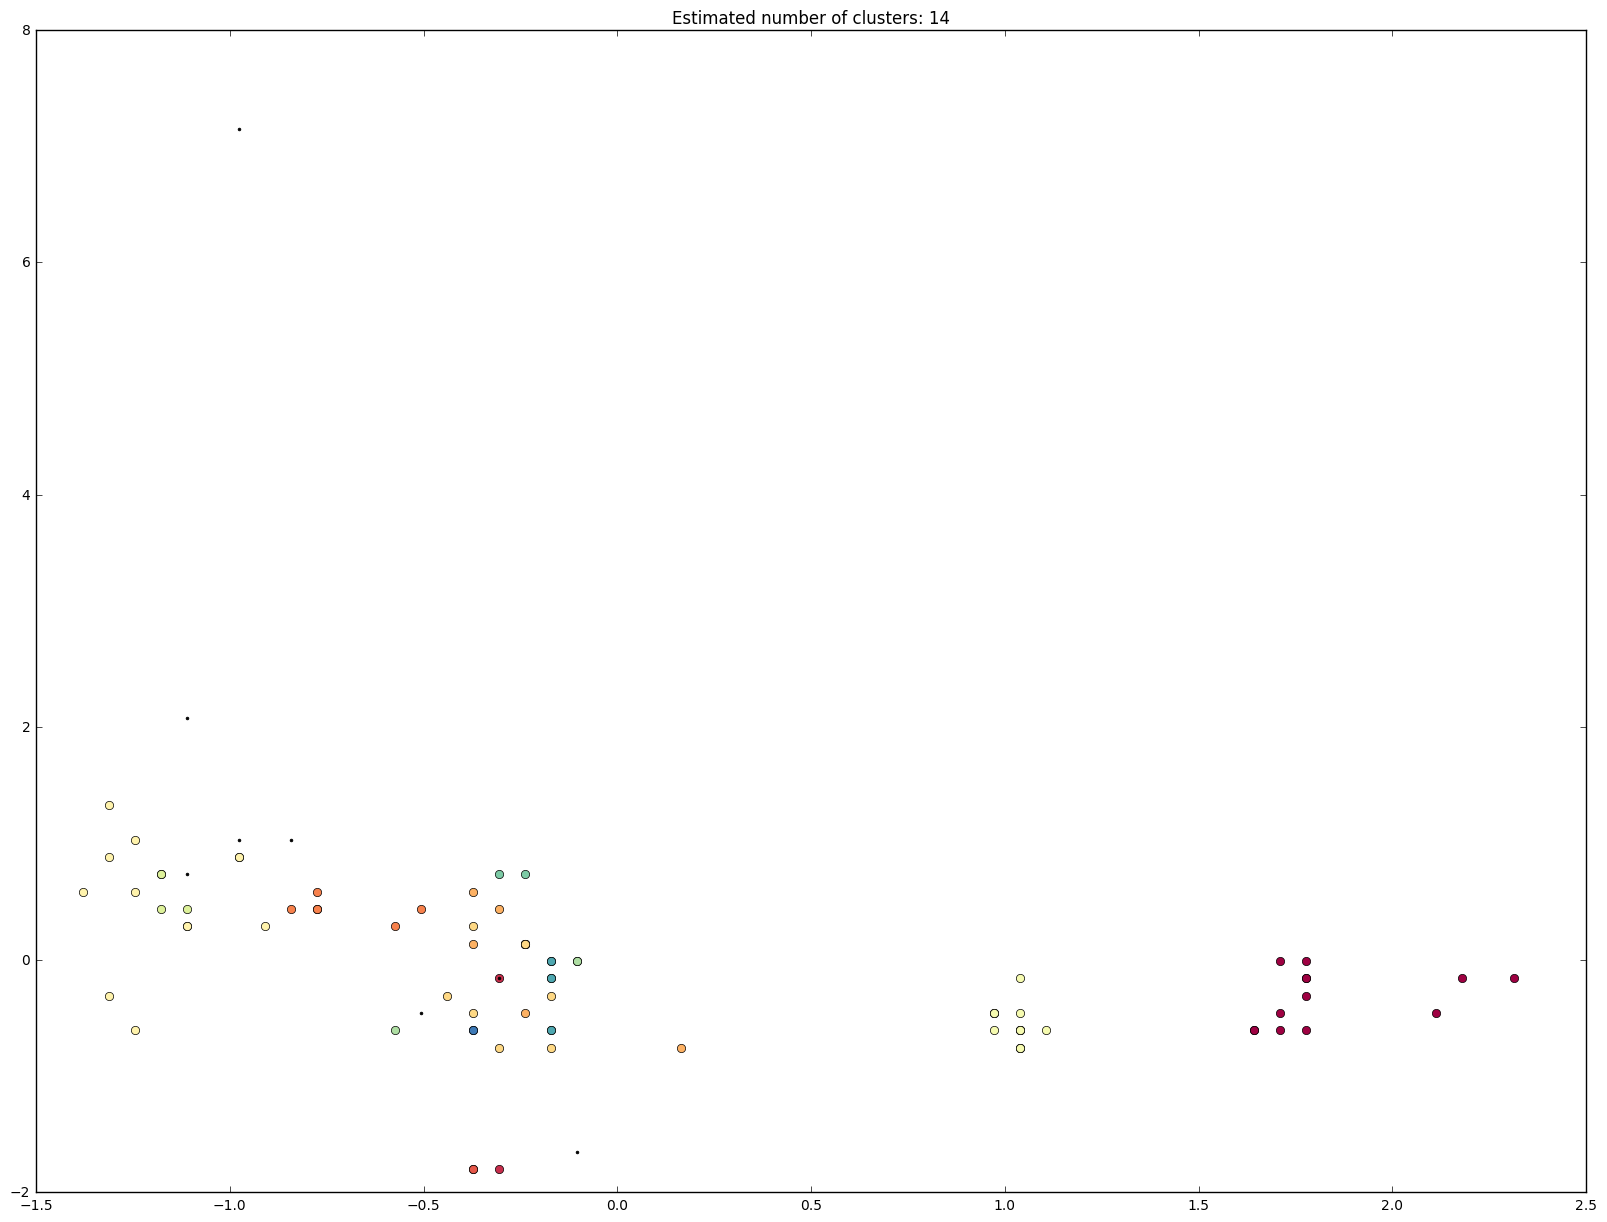

In [15]:
df_for_cluster = seq_match_df
#df_for_cluster = jaro_winkler_distance_df
#df_for_cluster = jaro_distance_df
#df_for_cluster = lev_distance_df
#df_for_cluster = dam_lev_distance_df
#df_for_cluster = ham_distance_df


stdsc = StandardScaler()
X = stdsc.fit_transform(df_for_cluster.values)
labels_true = df_for_cluster.index
db = DBSCAN(eps=5.0, min_samples=2).fit(X)
core_samples_mask = np.zeros_like(db.labels_, dtype=bool)
core_samples_mask[db.core_sample_indices_] = True
labels = db.labels_
n_clusters_ = len(set(labels))

print('Estimated number of clusters: %d' % n_clusters_)
print("Homogeneity: %0.3f" % homogeneity_score(labels_true, labels))
print("Completeness: %0.3f" % completeness_score(labels_true, labels))
print("V-measure: %0.3f" % v_measure_score(labels_true, labels))
print("Adjusted Rand Index: %0.3f"
      % adjusted_rand_score(labels_true, labels))
print("Adjusted Mutual Information: %0.3f"
      % adjusted_mutual_info_score(labels_true, labels))
#print("Silhouette Coefficient: %0.3f"
#      % metrics.silhouette_score(X, labels))

unique_labels = set(labels)
colors = plt.cm.Spectral(np.linspace(0, 1, len(unique_labels)))
plt.figure(figsize=(20, 15))
for k, col in zip(unique_labels, colors):
    if k == -1:
        # Black used for noise.
        col = 'k'

    class_member_mask = (labels == k)

    xy = X[class_member_mask & core_samples_mask]
    plt.plot(xy[:, 0], xy[:, 1], 'o', markerfacecolor=col,
             markeredgecolor='k', markersize=6)

    xy = X[class_member_mask & ~core_samples_mask]
    plt.plot(xy[:, 0], xy[:, 1], 'o', markerfacecolor=col,
             markeredgecolor='k', markersize=2)

plt.title('Estimated number of clusters: %d' % n_clusters_)
plt.show()

Computing embedding
Done.


C:\Users\Reid\Anaconda3\lib\site-packages\sklearn\manifold\spectral_embedding_.py:229: UserWarning: Graph is not fully connected, spectral embedding may not work as expected.
  warnings.warn("Graph is not fully connected, spectral embedding"


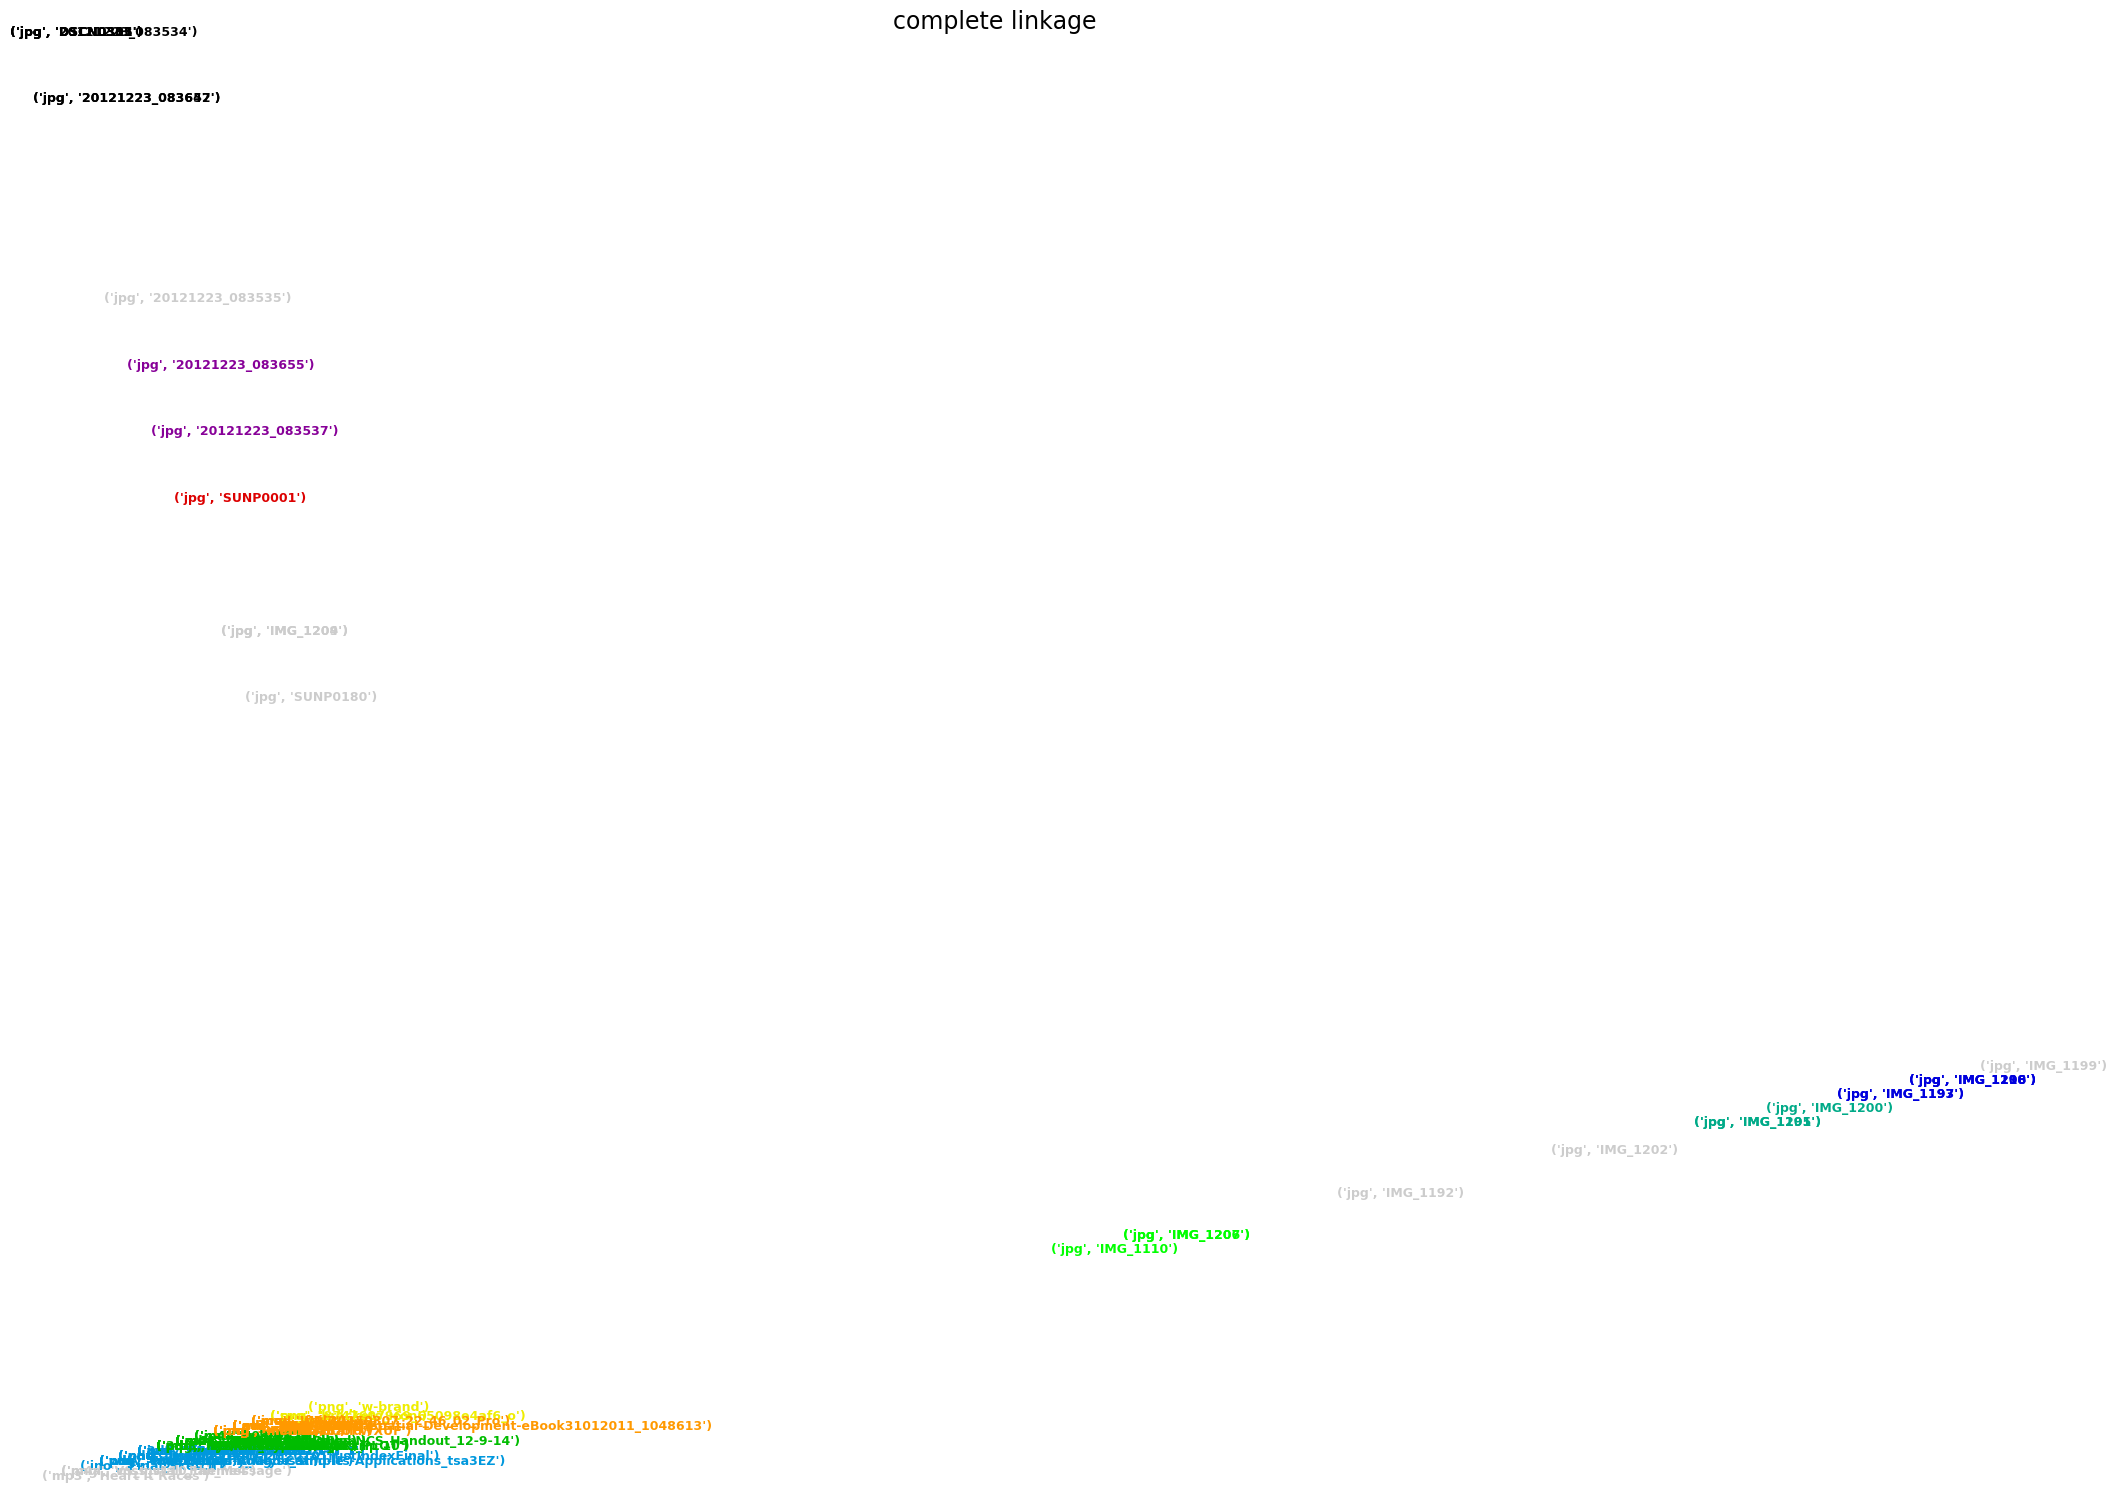

In [16]:
X = df_for_cluster.values
#X = stdsc.fit_transform(df_for_cluster.values)
y = df_for_cluster.index
#y = df_for_cluster.index.levels[0]
n_samples, n_features = X.shape

def plot_clustering(X_red, X, labels, title=None):
    x_min, x_max = np.min(X_red, axis=0), np.max(X_red, axis=0)
    X_red = (X_red - x_min) / (x_max - x_min)

    plt.figure(figsize=(20, 15))
    for i in range(X_red.shape[0]):
        plt.text(X_red[i, 0], X_red[i, 1], str(y[i]),
                 color=plt.cm.spectral(labels[i] / 10.),
                 fontdict={'weight': 'bold', 'size': 9})

    plt.xticks([])
    plt.yticks([])
    if title is not None:
        plt.title(title, size=17)
    plt.axis('off')
    plt.tight_layout()


print("Computing embedding")
X_red = manifold.SpectralEmbedding(n_components=2).fit_transform(X)
print("Done.")

#linkage = 'ward'
#linkage = 'average'
linkage = 'complete'

clustering = AgglomerativeClustering(linkage=linkage, n_clusters=17)
clustering.fit(X_red)
plot_clustering(X_red, X, clustering.labels_, "%s linkage" % linkage)

plt.show()

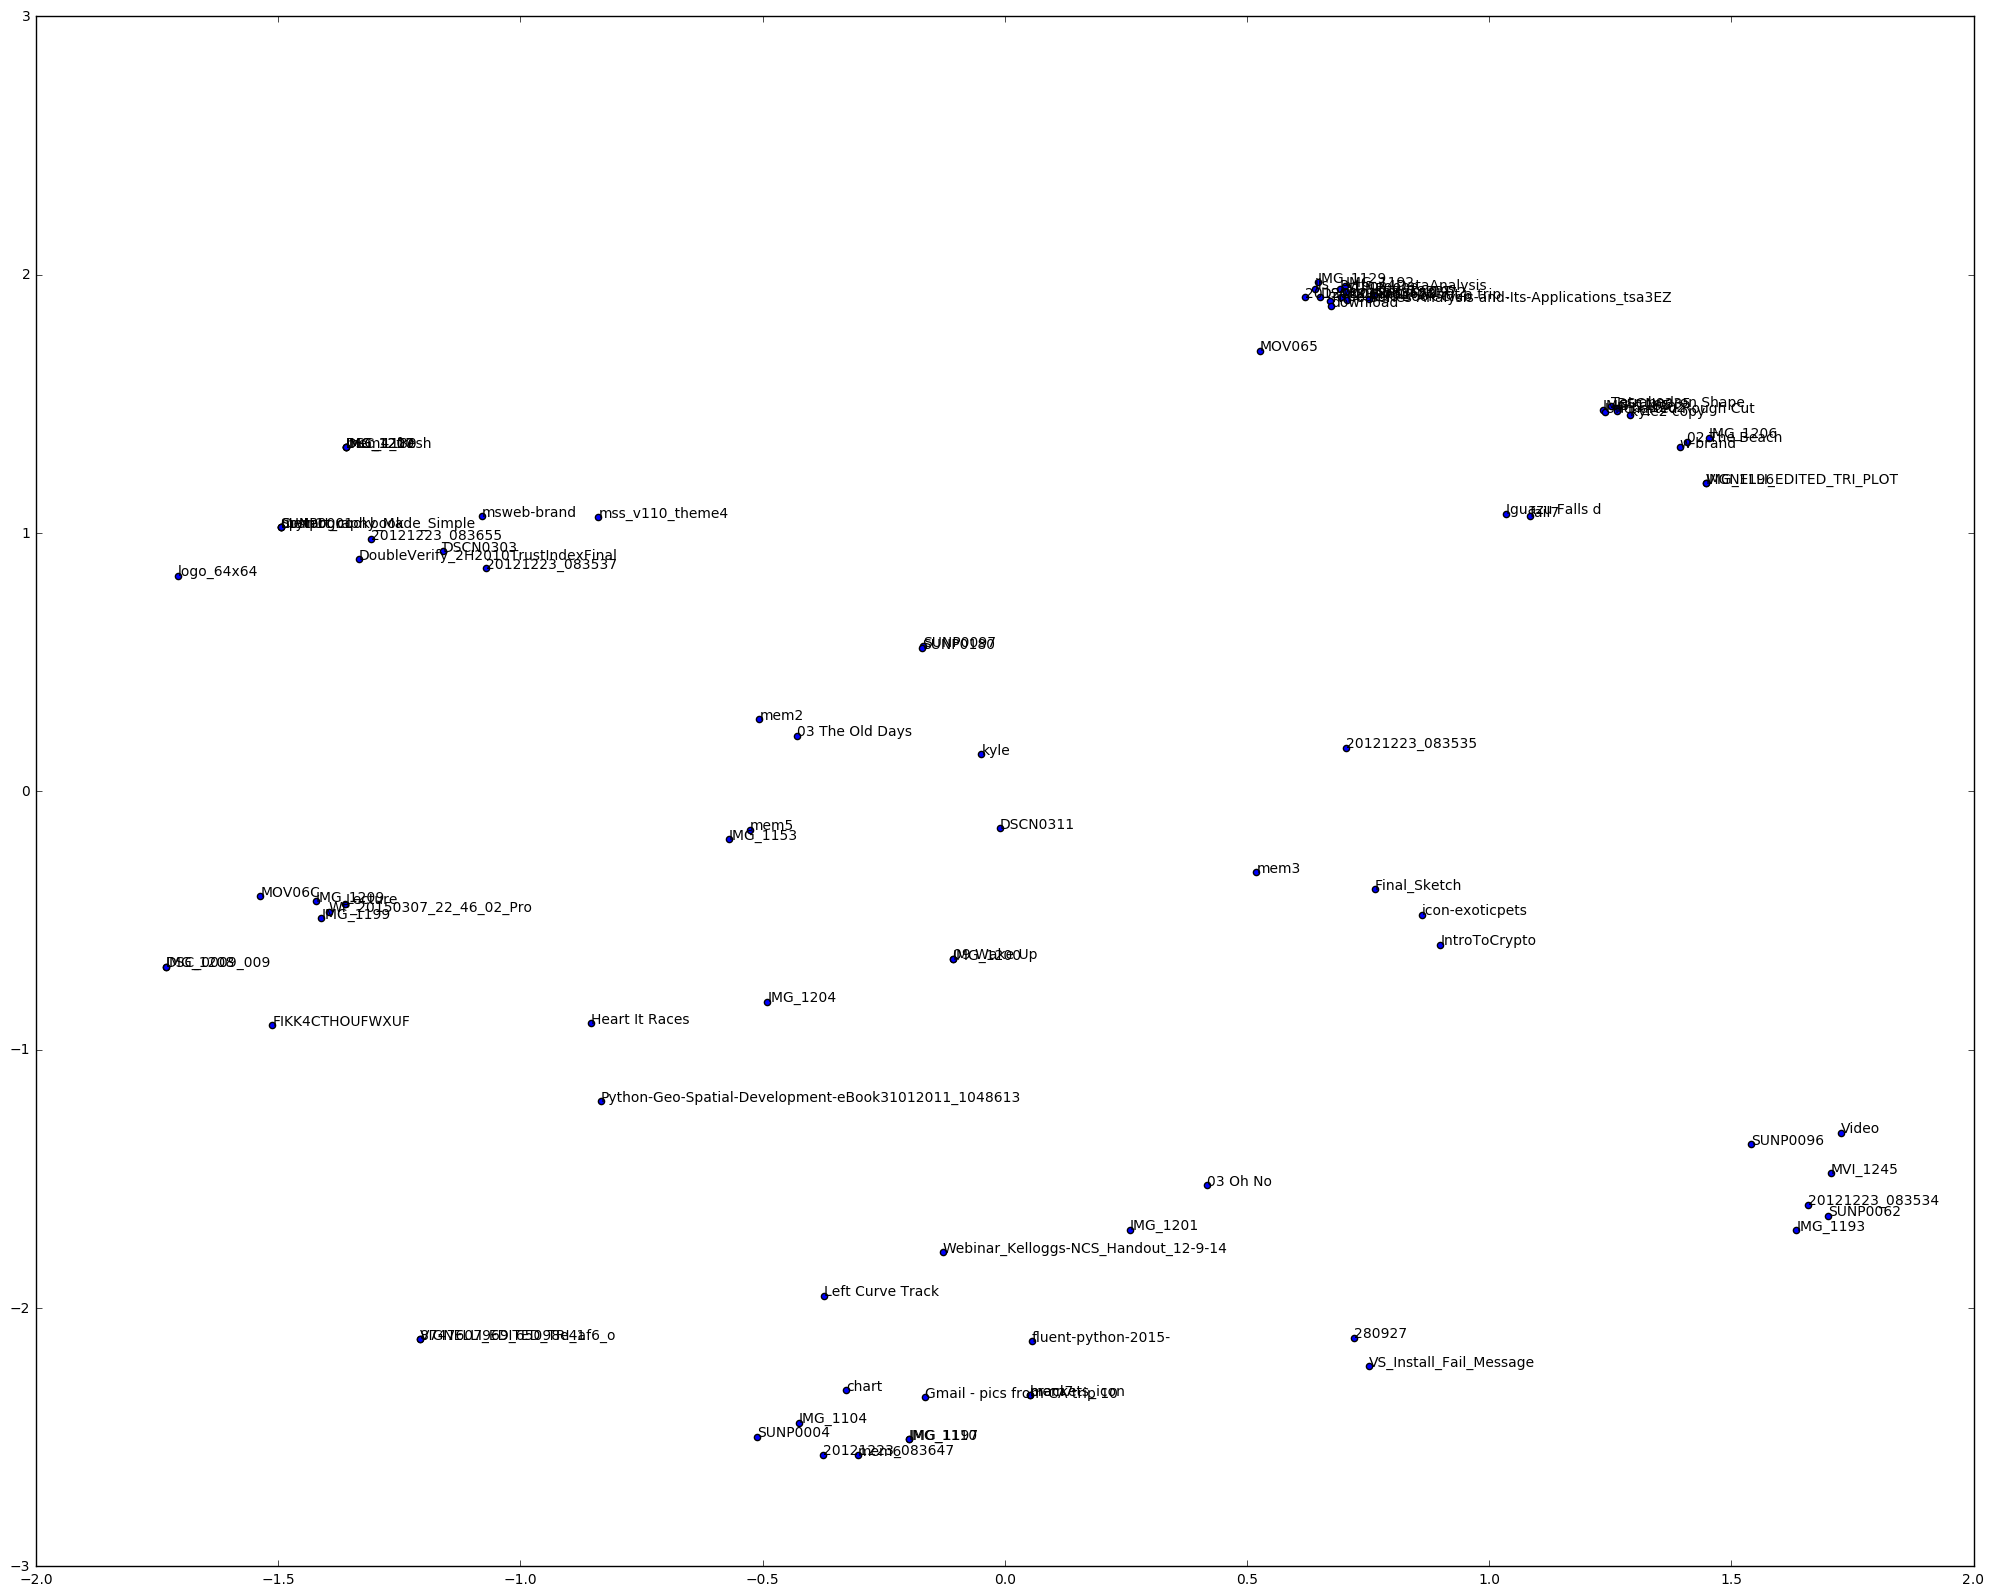

In [17]:
fnames = [ft for ft in df_for_cluster.index.levels[0]]
ftypes = [ft for ft in df_for_cluster.index.levels[1]]

mms = MinMaxScaler()

sym_array = stdsc.fit_transform(df_for_cluster.values.astype(np.float64))
norm_array = mms.fit_transform(df_for_cluster.values.astype(np.float64))
similarities = euclidean_distances(df_for_cluster.values.astype(np.float64))

mds = manifold.MDS(n_components=2, dissimilarity="precomputed", random_state=1)
pos = mds.fit_transform(similarities)
xs, ys = pos[:, 0], pos[:, 1]

fig, ax = plt.subplots(figsize=(25, 20))
for x, y, label in zip(xs, ys, ftypes):
    plt.scatter(x, y)
    plt.text(x, y, label)
